# Zadanie
Zadanie polega na własnoręcznym zaimplementowaniu algorytmu k-means. Algorytm powinien być zaimplementowany w oparciu o bibliotekę `Numpy`. Podczas implementacji nie wolno korzystać z bibliotek typu `sklearn`, które mają ten algorytm wbudowany. Dopuszczalne jest natomiast wykorzystywanie tego rodzaju bibliotek w celach porównawczych, do sprawdzenia czy nasz algorytm działa poprawnie. Ocenie podlega rozwiązanie i odpowiedź.


- Zaimplementuj `K-means` w przestrzeni dwuwymiarowej (każdy punkt ma dwie współrzędne). - *(dostateczny)*
- Zmniejsz problem związany z 'utknięciem' w lokalnym optimum poprzez wywołanie algorytmu 100 razy i wybranie rozwiązania z najmniejszą funkcją kosztu - *(dostateczny plus)*
- Zwizualizuj wyniki na wykresie - *(dobry)*
- Rozszerz swoją implementację o `K-means++` lub zmień ją tak by działała w n-wymiarowej przestrzeni - *(bardzo dobry)*

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Przykładowy kod do generowania punktów

In [73]:
points = np.vstack(((np.random.randn(150, 2) * 0.75 + np.array([1, 0])),
                  (np.random.randn(50, 2) * 0.25 + np.array([-0.5, 0.5])),
                  (np.random.randn(50, 2) * 0.5 + np.array([-0.5, -0.5]))))

Przykładowy kod do wyświetlenia wygenerowanych punktów

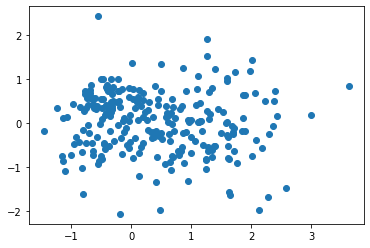

In [143]:
plt.scatter(points[:, 0], points[:, 1])
ax = plt.gca()

In [75]:
df_points = pd.DataFrame(points, columns=['f1','f2'])
points.shape

(250, 2)

Definiowanie zmiennych globalnych


*   `TRAINING EXAMPLES` - liczba punktów w zbiorze danych
*   `FEATURES` - 
*   `CLUSTERS` - liczba oznaczająca ilość klastrów (oznacza to również liczbę centroidów, które pojawią się wokół danych)
*   `ITERATIONS` - liczba iteracji

In [98]:
TRAINING_EXAMPLES = points.shape[0];
FEATURES = points.shape[1];
CLUSTERS = 3;
ITERATIONS = 100;
RANDOM_SEED = 10

Deklracja zmiennej `output_kmeans` w postaci dziennika, w któym `keys` będą oznaczać numer klastra, a `values` przyporządkowane punkty do danego klastra.

In [91]:
output_kmeans = {}

for i in range(CLUSTERS):
  output_kmeans[i] = [];

output_kmeans

{0: [], 1: [], 2: []}

Zaimpotowanie biblioteki `random` oraz ustalenie losowo centroidów z naszego zbioru danych. 
Stworzenie pustej tablicy centroidów jest poprzez odrówcenie tablicy 'points'. Po wykonaniu pętli mamy wymiary **features x clusters** gdzie każda kolumna jest centroidem dla jednego klustera.

In [178]:
import random

centroids = np.array([]).reshape(FEATURES,0);

for i in range(CLUSTERS):
  # random.seed(30)
  rand=random.randint(0,TRAINING_EXAMPLES-1,)
  centroids = np.c_[centroids, points[rand]]

centroids

array([[ 0.06264554, -0.30853284,  0.90306899],
       [-0.34655539,  0.81898122, -0.19887434]])

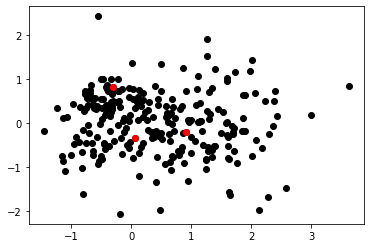

In [182]:
plt.scatter(points[:, 0], points[:, 1], c='black')
plt.scatter(centroids[0], centroids[1], c='red')
ax = plt.gca()

Dla każdego punktu ze zbioru danych musimy obliczyć eculidian distance od centroidy i przypisać klaster na podstawie odległości, która jest najmniejsza.

Znalezione odległości eukildesowe (tj. od każdego punktu do wszystkich centroidów) są zapisane w macierzy **training_example x clusters**, gdzie każdy wiersz zawiera odległość danego punktu od wszystkich centroid.

Następnie na podstawie `min_index` przeprowadza się grupowanie punktów ze zbioru danych - dopasowanie do danego klastera.

In [170]:
def my_kmean(iterations):
  for i in range(iterations):
      euclidian_distance = np.array([]).reshape(TRAINING_EXAMPLES, 0)

      for k in range(CLUSTERS):
        temp = np.power(points-centroids[:,k],2)
        current_distance = np.sum(temp, axis=1)  # don't forget: wybieranie kolumny przez advanced indexing  z numpy!
        euclidian_distance = np.c_[euclidian_distance, current_distance];

      min_index = np.argmin(euclidian_distance,axis=1)+1

      cluster_dict = {}

      for k in range(CLUSTERS):
        cluster_dict[k+1]= np.array([]).reshape(2,0)

      for x in range(TRAINING_EXAMPLES):
        cluster = min_index[x]
        cluster_dict[cluster] = np.c_[cluster_dict[cluster], points[x]]

      for k in range(CLUSTERS):
        cluster_dict[k+1] = cluster_dict[k+1].T

      for k in range(CLUSTERS):
        centroids[:,k] = np.mean(cluster_dict[k+1], axis=0)
      
      return cluster_dict

In [ ]:
output_kmeans = my_kmean(ITERATIONS)

output_kmeans


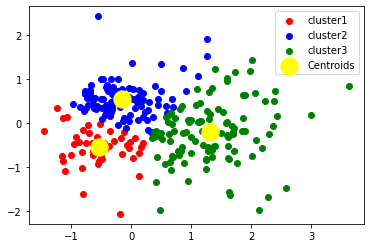

In [173]:
color=['red','blue','green','cyan','magenta']
labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
for k in range(CLUSTERS):
    plt.scatter(output_kmeans[k+1][:,0],output_kmeans[k+1][:,1],c=color[k],label=labels[k])
plt.scatter(centroids[0,:],centroids[1,:],s=300,c='yellow',label='Centroids')
plt.legend()
plt.show()

In [175]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_points)
y_kmeans = kmeans.predict(df_points)
df_points['sklearn_cluster'] = y_kmeans
sklearn_centers = kmeans.cluster_centers_

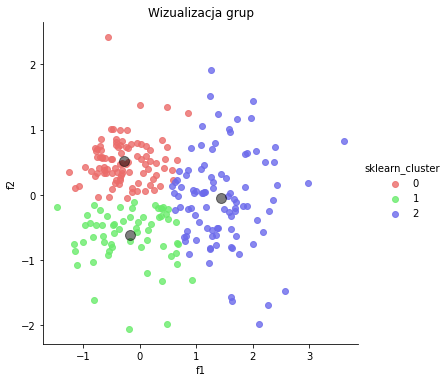

In [176]:
sns.lmplot(data=df_points, x='f1', y='f2', fit_reg=False, hue = 'sklearn_cluster', palette = ['#eb6c6a', '#6aeb6c', '#6c6aeb']).set(title='Wizualizacja grup')
plt.scatter(sklearn_centers[:, 0], sklearn_centers[:, 1], c='black', s=100, alpha=0.5)
plt.show()